# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

for rl in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=rl, reg=reg,
                      num_iters=4000, verbose=True)
        
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        acc = np.mean(y_val == y_val_pred)
        if acc > best_val:
            best_val = acc
            best_svm = svm
        results[(rl, reg)] = (train_acc, acc)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 4000: loss 87.303925
iteration 100 / 4000: loss 85.752666
iteration 200 / 4000: loss 84.218307
iteration 300 / 4000: loss 82.748156
iteration 400 / 4000: loss 81.265475
iteration 500 / 4000: loss 79.849159
iteration 600 / 4000: loss 78.460973
iteration 700 / 4000: loss 77.069415
iteration 800 / 4000: loss 75.723547
iteration 900 / 4000: loss 74.407274
iteration 1000 / 4000: loss 73.086163
iteration 1100 / 4000: loss 71.831139
iteration 1200 / 4000: loss 70.569998
iteration 1300 / 4000: loss 69.359774
iteration 1400 / 4000: loss 68.181717
iteration 1500 / 4000: loss 67.004223
iteration 1600 / 4000: loss 65.868012
iteration 1700 / 4000: loss 64.740254
iteration 1800 / 4000: loss 63.625722
iteration 1900 / 4000: loss 62.551531
iteration 2000 / 4000: loss 61.481782
iteration 2100 / 4000: loss 60.442987
iteration 2200 / 4000: loss 59.422866
iteration 2300 / 4000: loss 58.434931
iteration 2400 / 4000: loss 57.457627
iteration 2500 / 4000: loss 56.505390
iteration 2600 / 4000: l

iteration 2200 / 4000: loss 8.999997
iteration 2300 / 4000: loss 8.999996
iteration 2400 / 4000: loss 8.999997
iteration 2500 / 4000: loss 8.999997
iteration 2600 / 4000: loss 8.999997
iteration 2700 / 4000: loss 8.999997
iteration 2800 / 4000: loss 8.999996
iteration 2900 / 4000: loss 8.999997
iteration 3000 / 4000: loss 8.999997
iteration 3100 / 4000: loss 8.999996
iteration 3200 / 4000: loss 8.999997
iteration 3300 / 4000: loss 8.999997
iteration 3400 / 4000: loss 8.999997
iteration 3500 / 4000: loss 8.999997
iteration 3600 / 4000: loss 8.999997
iteration 3700 / 4000: loss 8.999997
iteration 3800 / 4000: loss 8.999996
iteration 3900 / 4000: loss 8.999996
iteration 0 / 4000: loss 91.077806
iteration 100 / 4000: loss 19.998679
iteration 200 / 4000: loss 10.473861
iteration 300 / 4000: loss 9.196655
iteration 400 / 4000: loss 9.025934
iteration 500 / 4000: loss 9.003135
iteration 600 / 4000: loss 9.000057
iteration 700 / 4000: loss 8.999717
iteration 800 / 4000: loss 8.999693
iteration

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


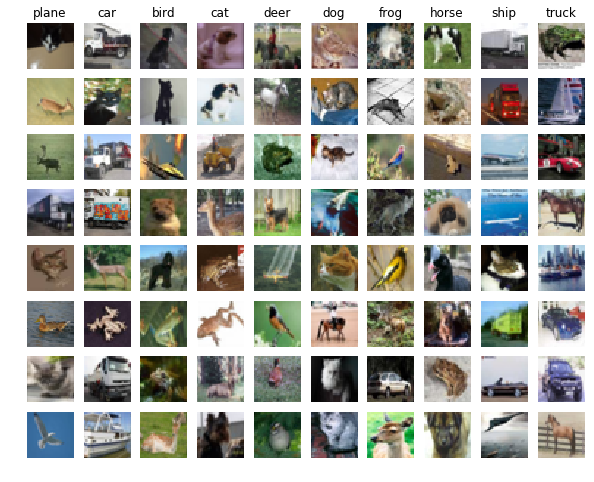

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
print(X_train_feats.shape)
print(input_size)

(49000, 155)
3072


In [22]:
from cs231n.classifiers.neural_net import TwoLayerNet
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
hidden_size = range(30, 300, 25)

results = {}
best_val_acc = 0
best_net = None

# learning_rates = np.array([0.7, 0.8, 0.9, 1, 1.1])*1e-3
# regularization_strengths = [0.75, 1, 1.25]
regularization_strengths = np.linspace(0, 0.01, num=4)
learning_rates = np.array([1, 1.6, 2.5])*1e-1


for hs in hidden_size:
    for lr in learning_rates:
        for reg in regularization_strengths:
            print((hs,lr,reg))
           
        
            input_size = 32 * 32 * 3
            hidden_size = hs
            num_classes = 10
            net = TwoLayerNet(X_train_feats.shape[1], hidden_size, num_classes)

            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=10000, batch_size=30,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=True)
        
        
            
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net         
            results[(hs,lr,reg)] = val_acc

# Print out results.
for hs,lr, reg in sorted(results):
    val_acc = results[(hs, lr, reg)]
    print( 'hs %d lr %e reg %e val accuracy: %f' % (hs, lr, reg,  val_acc))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(30, 0.1, 0.0)
iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 2.309078
iteration 200 / 10000: loss 2.287298
iteration 300 / 10000: loss 1.997075
iteration 400 / 10000: loss 1.820274
iteration 500 / 10000: loss 1.868824
iteration 600 / 10000: loss 1.402877
iteration 700 / 10000: loss 1.578416
iteration 800 / 10000: loss 1.183420
iteration 900 / 10000: loss 1.745677
iteration 1000 / 10000: loss 1.591741
iteration 1100 / 10000: loss 1.369080
iteration 1200 / 10000: loss 1.709363
iteration 1300 / 10000: loss 1.390973
iteration 1400 / 10000: loss 1.238803
iteration 1500 / 10000: loss 1.461676
iteration 1600 / 10000: loss 1.065859
iteration 1700 / 10000: loss 1.545536
iteration 1800 / 10000: loss 1.265333
iteration 1900 / 10000: loss 1.150646
iteration 2000 / 10000: loss 1.625657
iteration 2100 / 10000: loss 1.018533
iteration 2200 / 10000: loss 1.421224
iteration 2300 / 10000: loss 0.979910
iteration 2400 / 10000: loss 1.244078
iteration 2500 / 10000: loss 1.135804
iteration

iteration 1900 / 10000: loss 1.489104
iteration 2000 / 10000: loss 1.493377
iteration 2100 / 10000: loss 1.409703
iteration 2200 / 10000: loss 1.301644
iteration 2300 / 10000: loss 1.879739
iteration 2400 / 10000: loss 1.450246
iteration 2500 / 10000: loss 1.538093
iteration 2600 / 10000: loss 1.424201
iteration 2700 / 10000: loss 1.529187
iteration 2800 / 10000: loss 1.511439
iteration 2900 / 10000: loss 1.678100
iteration 3000 / 10000: loss 1.532165
iteration 3100 / 10000: loss 1.420835
iteration 3200 / 10000: loss 1.694017
iteration 3300 / 10000: loss 1.627551
iteration 3400 / 10000: loss 1.368636
iteration 3500 / 10000: loss 1.324699
iteration 3600 / 10000: loss 1.518343
iteration 3700 / 10000: loss 1.626563
iteration 3800 / 10000: loss 1.609025
iteration 3900 / 10000: loss 1.628752
iteration 4000 / 10000: loss 1.509103
iteration 4100 / 10000: loss 1.567340
iteration 4200 / 10000: loss 1.765905
iteration 4300 / 10000: loss 1.592551
iteration 4400 / 10000: loss 1.591221
iteration 45

iteration 3500 / 10000: loss 1.063464
iteration 3600 / 10000: loss 1.355385
iteration 3700 / 10000: loss 1.351003
iteration 3800 / 10000: loss 1.012174
iteration 3900 / 10000: loss 1.202384
iteration 4000 / 10000: loss 1.123452
iteration 4100 / 10000: loss 1.266197
iteration 4200 / 10000: loss 1.304136
iteration 4300 / 10000: loss 1.653968
iteration 4400 / 10000: loss 1.146886
iteration 4500 / 10000: loss 1.064589
iteration 4600 / 10000: loss 1.119131
iteration 4700 / 10000: loss 1.703676
iteration 4800 / 10000: loss 1.241669
iteration 4900 / 10000: loss 1.230393
iteration 5000 / 10000: loss 1.109144
iteration 5100 / 10000: loss 1.296307
iteration 5200 / 10000: loss 1.095028
iteration 5300 / 10000: loss 1.173788
iteration 5400 / 10000: loss 1.606264
iteration 5500 / 10000: loss 1.345218
iteration 5600 / 10000: loss 1.146560
iteration 5700 / 10000: loss 1.253035
iteration 5800 / 10000: loss 1.514034
iteration 5900 / 10000: loss 1.266537
iteration 6000 / 10000: loss 1.165090
iteration 61

iteration 5300 / 10000: loss 1.487131
iteration 5400 / 10000: loss 2.088744
iteration 5500 / 10000: loss 1.511611
iteration 5600 / 10000: loss 1.155794
iteration 5700 / 10000: loss 1.736389
iteration 5800 / 10000: loss 1.693116
iteration 5900 / 10000: loss 1.563367
iteration 6000 / 10000: loss 1.517684
iteration 6100 / 10000: loss 1.736984
iteration 6200 / 10000: loss 1.454227
iteration 6300 / 10000: loss 1.783627
iteration 6400 / 10000: loss 1.429936
iteration 6500 / 10000: loss 1.407418
iteration 6600 / 10000: loss 1.747222
iteration 6700 / 10000: loss 1.849439
iteration 6800 / 10000: loss 1.510437
iteration 6900 / 10000: loss 1.895331
iteration 7000 / 10000: loss 1.415477
iteration 7100 / 10000: loss 1.869287
iteration 7200 / 10000: loss 1.953554
iteration 7300 / 10000: loss 1.715005
iteration 7400 / 10000: loss 1.223461
iteration 7500 / 10000: loss 1.600818
iteration 7600 / 10000: loss 1.768165
iteration 7700 / 10000: loss 1.487271
iteration 7800 / 10000: loss 1.566550
iteration 79

iteration 7100 / 10000: loss 1.149953
iteration 7200 / 10000: loss 1.862306
iteration 7300 / 10000: loss 1.469358
iteration 7400 / 10000: loss 1.333332
iteration 7500 / 10000: loss 0.779615
iteration 7600 / 10000: loss 1.415966
iteration 7700 / 10000: loss 1.304146
iteration 7800 / 10000: loss 1.593745
iteration 7900 / 10000: loss 1.179835
iteration 8000 / 10000: loss 1.112088
iteration 8100 / 10000: loss 1.447650
iteration 8200 / 10000: loss 1.259349
iteration 8300 / 10000: loss 0.982938
iteration 8400 / 10000: loss 1.489935
iteration 8500 / 10000: loss 1.355000
iteration 8600 / 10000: loss 1.562022
iteration 8700 / 10000: loss 1.373119
iteration 8800 / 10000: loss 1.575129
iteration 8900 / 10000: loss 0.972792
iteration 9000 / 10000: loss 1.012908
iteration 9100 / 10000: loss 1.437425
iteration 9200 / 10000: loss 1.540783
iteration 9300 / 10000: loss 1.245204
iteration 9400 / 10000: loss 1.809303
iteration 9500 / 10000: loss 1.131179
iteration 9600 / 10000: loss 1.277655
iteration 97

iteration 8700 / 10000: loss 1.599279
iteration 8800 / 10000: loss 1.720105
iteration 8900 / 10000: loss 1.865373
iteration 9000 / 10000: loss 1.443689
iteration 9100 / 10000: loss 1.901951
iteration 9200 / 10000: loss 1.497797
iteration 9300 / 10000: loss 1.660184
iteration 9400 / 10000: loss 2.006995
iteration 9500 / 10000: loss 1.672492
iteration 9600 / 10000: loss 1.591554
iteration 9700 / 10000: loss 1.794583
iteration 9800 / 10000: loss 1.701470
iteration 9900 / 10000: loss 1.746848
(30, 0.25, 0.01)
iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 2.234712
iteration 200 / 10000: loss 1.934096
iteration 300 / 10000: loss 1.539663
iteration 400 / 10000: loss 1.703278
iteration 500 / 10000: loss 1.510370
iteration 600 / 10000: loss 1.870694
iteration 700 / 10000: loss 1.815770
iteration 800 / 10000: loss 1.941981
iteration 900 / 10000: loss 1.391007
iteration 1000 / 10000: loss 1.927027
iteration 1100 / 10000: loss 2.224732
iteration 1200 / 10000: loss 2.102497
iterati

iteration 300 / 10000: loss 2.021514
iteration 400 / 10000: loss 1.778127
iteration 500 / 10000: loss 2.020997
iteration 600 / 10000: loss 1.014146
iteration 700 / 10000: loss 1.677473
iteration 800 / 10000: loss 1.640382
iteration 900 / 10000: loss 1.508284
iteration 1000 / 10000: loss 1.338816
iteration 1100 / 10000: loss 1.421388
iteration 1200 / 10000: loss 1.257038
iteration 1300 / 10000: loss 1.441746
iteration 1400 / 10000: loss 1.577323
iteration 1500 / 10000: loss 1.519985
iteration 1600 / 10000: loss 1.428191
iteration 1700 / 10000: loss 1.800682
iteration 1800 / 10000: loss 1.431596
iteration 1900 / 10000: loss 1.363288
iteration 2000 / 10000: loss 1.456074
iteration 2100 / 10000: loss 1.892025
iteration 2200 / 10000: loss 1.372049
iteration 2300 / 10000: loss 1.337527
iteration 2400 / 10000: loss 1.563268
iteration 2500 / 10000: loss 1.416564
iteration 2600 / 10000: loss 1.706293
iteration 2700 / 10000: loss 1.173415
iteration 2800 / 10000: loss 1.525662
iteration 2900 / 10

iteration 2300 / 10000: loss 1.597477
iteration 2400 / 10000: loss 1.493927
iteration 2500 / 10000: loss 1.324819
iteration 2600 / 10000: loss 1.759595
iteration 2700 / 10000: loss 1.429849
iteration 2800 / 10000: loss 1.507234
iteration 2900 / 10000: loss 1.651067
iteration 3000 / 10000: loss 1.592523
iteration 3100 / 10000: loss 1.567592
iteration 3200 / 10000: loss 1.696719
iteration 3300 / 10000: loss 1.350923
iteration 3400 / 10000: loss 1.657148
iteration 3500 / 10000: loss 1.519247
iteration 3600 / 10000: loss 1.703474
iteration 3700 / 10000: loss 1.732815
iteration 3800 / 10000: loss 1.874883
iteration 3900 / 10000: loss 1.827937
iteration 4000 / 10000: loss 1.675799
iteration 4100 / 10000: loss 1.546540
iteration 4200 / 10000: loss 1.712408
iteration 4300 / 10000: loss 1.667752
iteration 4400 / 10000: loss 1.762077
iteration 4500 / 10000: loss 1.303640
iteration 4600 / 10000: loss 1.400197
iteration 4700 / 10000: loss 1.918569
iteration 4800 / 10000: loss 1.634261
iteration 49

iteration 3800 / 10000: loss 1.287768
iteration 3900 / 10000: loss 1.314724
iteration 4000 / 10000: loss 1.337777
iteration 4100 / 10000: loss 1.779164
iteration 4200 / 10000: loss 1.441060
iteration 4300 / 10000: loss 1.379145
iteration 4400 / 10000: loss 1.772291
iteration 4500 / 10000: loss 1.605024
iteration 4600 / 10000: loss 1.350244
iteration 4700 / 10000: loss 1.238260
iteration 4800 / 10000: loss 1.645055
iteration 4900 / 10000: loss 1.806647
iteration 5000 / 10000: loss 1.325449
iteration 5100 / 10000: loss 1.556776
iteration 5200 / 10000: loss 1.541313
iteration 5300 / 10000: loss 1.679952
iteration 5400 / 10000: loss 1.507182
iteration 5500 / 10000: loss 1.454777
iteration 5600 / 10000: loss 1.233092
iteration 5700 / 10000: loss 1.375795
iteration 5800 / 10000: loss 2.126382
iteration 5900 / 10000: loss 1.376874
iteration 6000 / 10000: loss 1.326322
iteration 6100 / 10000: loss 1.218660
iteration 6200 / 10000: loss 1.143896
iteration 6300 / 10000: loss 1.536088
iteration 64

iteration 5300 / 10000: loss 1.716202
iteration 5400 / 10000: loss 1.696388
iteration 5500 / 10000: loss 1.738320
iteration 5600 / 10000: loss 1.422235
iteration 5700 / 10000: loss 1.435410
iteration 5800 / 10000: loss 1.893079
iteration 5900 / 10000: loss 1.703153
iteration 6000 / 10000: loss 1.581782
iteration 6100 / 10000: loss 1.687985
iteration 6200 / 10000: loss 1.780385
iteration 6300 / 10000: loss 1.556985
iteration 6400 / 10000: loss 1.575532
iteration 6500 / 10000: loss 1.765654
iteration 6600 / 10000: loss 1.602904
iteration 6700 / 10000: loss 1.703947
iteration 6800 / 10000: loss 1.911205
iteration 6900 / 10000: loss 1.617618
iteration 7000 / 10000: loss 1.855728
iteration 7100 / 10000: loss 1.173397
iteration 7200 / 10000: loss 1.784145
iteration 7300 / 10000: loss 1.766390
iteration 7400 / 10000: loss 1.865308
iteration 7500 / 10000: loss 1.395972
iteration 7600 / 10000: loss 1.434952
iteration 7700 / 10000: loss 1.780459
iteration 7800 / 10000: loss 1.538217
iteration 79

iteration 6800 / 10000: loss 1.386746
iteration 6900 / 10000: loss 1.660885
iteration 7000 / 10000: loss 1.412009
iteration 7100 / 10000: loss 1.212565
iteration 7200 / 10000: loss 1.559755
iteration 7300 / 10000: loss 1.754607
iteration 7400 / 10000: loss 1.782527
iteration 7500 / 10000: loss 1.722853
iteration 7600 / 10000: loss 1.444284
iteration 7700 / 10000: loss 1.603603
iteration 7800 / 10000: loss 1.372147
iteration 7900 / 10000: loss 1.264149
iteration 8000 / 10000: loss 1.619597
iteration 8100 / 10000: loss 1.312960
iteration 8200 / 10000: loss 1.427571
iteration 8300 / 10000: loss 1.760455
iteration 8400 / 10000: loss 1.385447
iteration 8500 / 10000: loss 1.412769
iteration 8600 / 10000: loss 1.285678
iteration 8700 / 10000: loss 1.481877
iteration 8800 / 10000: loss 1.699799
iteration 8900 / 10000: loss 1.162264
iteration 9000 / 10000: loss 1.395387
iteration 9100 / 10000: loss 2.175439
iteration 9200 / 10000: loss 1.603075
iteration 9300 / 10000: loss 1.322117
iteration 94

iteration 8300 / 10000: loss 1.690332
iteration 8400 / 10000: loss 1.635618
iteration 8500 / 10000: loss 1.717213
iteration 8600 / 10000: loss 1.464518
iteration 8700 / 10000: loss 1.690750
iteration 8800 / 10000: loss 1.593904
iteration 8900 / 10000: loss 1.469094
iteration 9000 / 10000: loss 1.807594
iteration 9100 / 10000: loss 1.435497
iteration 9200 / 10000: loss 1.623940
iteration 9300 / 10000: loss 2.214940
iteration 9400 / 10000: loss 1.846663
iteration 9500 / 10000: loss 1.455530
iteration 9600 / 10000: loss 1.748416
iteration 9700 / 10000: loss 1.526811
iteration 9800 / 10000: loss 1.836305
iteration 9900 / 10000: loss 1.814658
(80, 0.1, 0.0)
iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 2.307081
iteration 200 / 10000: loss 2.166690
iteration 300 / 10000: loss 2.016115
iteration 400 / 10000: loss 1.668071
iteration 500 / 10000: loss 1.703931
iteration 600 / 10000: loss 1.567425
iteration 700 / 10000: loss 1.383242
iteration 800 / 10000: loss 1.514255
iteratio

iteration 200 / 10000: loss 2.266761
iteration 300 / 10000: loss 1.907957
iteration 400 / 10000: loss 1.891249
iteration 500 / 10000: loss 1.650055
iteration 600 / 10000: loss 1.752976
iteration 700 / 10000: loss 1.299124
iteration 800 / 10000: loss 1.570193
iteration 900 / 10000: loss 1.483482
iteration 1000 / 10000: loss 1.612450
iteration 1100 / 10000: loss 1.664300
iteration 1200 / 10000: loss 1.553558
iteration 1300 / 10000: loss 1.675337
iteration 1400 / 10000: loss 1.600419
iteration 1500 / 10000: loss 1.819692
iteration 1600 / 10000: loss 1.428820
iteration 1700 / 10000: loss 1.554902
iteration 1800 / 10000: loss 1.260254
iteration 1900 / 10000: loss 1.697244
iteration 2000 / 10000: loss 1.434691
iteration 2100 / 10000: loss 1.784035
iteration 2200 / 10000: loss 1.562402
iteration 2300 / 10000: loss 1.636196
iteration 2400 / 10000: loss 1.077419
iteration 2500 / 10000: loss 1.356136
iteration 2600 / 10000: loss 1.701643
iteration 2700 / 10000: loss 1.362734
iteration 2800 / 100

iteration 2100 / 10000: loss 0.989967
iteration 2200 / 10000: loss 1.129429
iteration 2300 / 10000: loss 1.449040
iteration 2400 / 10000: loss 1.081463
iteration 2500 / 10000: loss 1.289155
iteration 2600 / 10000: loss 1.436840
iteration 2700 / 10000: loss 1.382729
iteration 2800 / 10000: loss 1.233238
iteration 2900 / 10000: loss 1.190434
iteration 3000 / 10000: loss 1.238857
iteration 3100 / 10000: loss 1.606083
iteration 3200 / 10000: loss 1.240251
iteration 3300 / 10000: loss 1.352349
iteration 3400 / 10000: loss 1.186014
iteration 3500 / 10000: loss 1.503402
iteration 3600 / 10000: loss 0.630257
iteration 3700 / 10000: loss 0.734941
iteration 3800 / 10000: loss 1.048728
iteration 3900 / 10000: loss 1.544584
iteration 4000 / 10000: loss 1.171273
iteration 4100 / 10000: loss 1.310328
iteration 4200 / 10000: loss 1.360923
iteration 4300 / 10000: loss 1.406027
iteration 4400 / 10000: loss 1.152362
iteration 4500 / 10000: loss 1.268159
iteration 4600 / 10000: loss 1.248804
iteration 47

iteration 3800 / 10000: loss 1.669517
iteration 3900 / 10000: loss 1.384242
iteration 4000 / 10000: loss 1.639860
iteration 4100 / 10000: loss 1.640912
iteration 4200 / 10000: loss 1.488054
iteration 4300 / 10000: loss 1.567176
iteration 4400 / 10000: loss 1.740105
iteration 4500 / 10000: loss 1.124339
iteration 4600 / 10000: loss 1.811647
iteration 4700 / 10000: loss 1.499488
iteration 4800 / 10000: loss 1.586183
iteration 4900 / 10000: loss 1.429456
iteration 5000 / 10000: loss 1.809977
iteration 5100 / 10000: loss 1.486814
iteration 5200 / 10000: loss 1.496034
iteration 5300 / 10000: loss 1.923679
iteration 5400 / 10000: loss 1.395403
iteration 5500 / 10000: loss 1.737034
iteration 5600 / 10000: loss 1.638931
iteration 5700 / 10000: loss 1.648929
iteration 5800 / 10000: loss 1.875544
iteration 5900 / 10000: loss 1.663655
iteration 6000 / 10000: loss 1.667423
iteration 6100 / 10000: loss 1.666560
iteration 6200 / 10000: loss 1.714165
iteration 6300 / 10000: loss 1.908365
iteration 64

iteration 5600 / 10000: loss 1.067979
iteration 5700 / 10000: loss 1.331141
iteration 5800 / 10000: loss 0.990779
iteration 5900 / 10000: loss 1.344606
iteration 6000 / 10000: loss 0.887932
iteration 6100 / 10000: loss 1.424081
iteration 6200 / 10000: loss 1.092626
iteration 6300 / 10000: loss 1.407382
iteration 6400 / 10000: loss 1.183049
iteration 6500 / 10000: loss 1.542834
iteration 6600 / 10000: loss 0.984408
iteration 6700 / 10000: loss 0.979443
iteration 6800 / 10000: loss 1.287974
iteration 6900 / 10000: loss 2.130310
iteration 7000 / 10000: loss 0.827495
iteration 7100 / 10000: loss 0.908215
iteration 7200 / 10000: loss 1.212856
iteration 7300 / 10000: loss 1.251143
iteration 7400 / 10000: loss 0.944789
iteration 7500 / 10000: loss 0.699729
iteration 7600 / 10000: loss 1.319556
iteration 7700 / 10000: loss 1.155495
iteration 7800 / 10000: loss 1.362798
iteration 7900 / 10000: loss 0.951680
iteration 8000 / 10000: loss 1.328123
iteration 8100 / 10000: loss 1.019786
iteration 82

iteration 7300 / 10000: loss 1.569080
iteration 7400 / 10000: loss 2.154600
iteration 7500 / 10000: loss 1.572475
iteration 7600 / 10000: loss 1.427285
iteration 7700 / 10000: loss 1.928723
iteration 7800 / 10000: loss 2.097555
iteration 7900 / 10000: loss 1.001456
iteration 8000 / 10000: loss 1.853569
iteration 8100 / 10000: loss 1.789034
iteration 8200 / 10000: loss 1.869259
iteration 8300 / 10000: loss 1.485271
iteration 8400 / 10000: loss 1.370886
iteration 8500 / 10000: loss 1.478636
iteration 8600 / 10000: loss 1.594285
iteration 8700 / 10000: loss 1.789286
iteration 8800 / 10000: loss 1.548619
iteration 8900 / 10000: loss 1.630838
iteration 9000 / 10000: loss 1.834172
iteration 9100 / 10000: loss 1.454175
iteration 9200 / 10000: loss 1.540339
iteration 9300 / 10000: loss 1.455825
iteration 9400 / 10000: loss 2.039976
iteration 9500 / 10000: loss 1.717904
iteration 9600 / 10000: loss 1.554768
iteration 9700 / 10000: loss 1.692990
iteration 9800 / 10000: loss 1.786523
iteration 99

iteration 9000 / 10000: loss 1.084718
iteration 9100 / 10000: loss 1.553731
iteration 9200 / 10000: loss 1.005313
iteration 9300 / 10000: loss 1.104669
iteration 9400 / 10000: loss 1.424079
iteration 9500 / 10000: loss 0.828253
iteration 9600 / 10000: loss 1.155203
iteration 9700 / 10000: loss 1.108623
iteration 9800 / 10000: loss 1.265969
iteration 9900 / 10000: loss 0.840062
(105, 0.1, 0.0033333333333333335)
iteration 0 / 10000: loss 2.302586
iteration 100 / 10000: loss 2.307855
iteration 200 / 10000: loss 2.227796
iteration 300 / 10000: loss 1.961811
iteration 400 / 10000: loss 1.587166
iteration 500 / 10000: loss 1.822496
iteration 600 / 10000: loss 1.542360
iteration 700 / 10000: loss 1.408599
iteration 800 / 10000: loss 1.428271
iteration 900 / 10000: loss 1.389340
iteration 1000 / 10000: loss 1.247475
iteration 1100 / 10000: loss 1.822848
iteration 1200 / 10000: loss 1.631269
iteration 1300 / 10000: loss 1.389549
iteration 1400 / 10000: loss 1.512382
iteration 1500 / 10000: loss

iteration 600 / 10000: loss 1.904006
iteration 700 / 10000: loss 1.467610
iteration 800 / 10000: loss 1.459475
iteration 900 / 10000: loss 1.501062
iteration 1000 / 10000: loss 1.223404
iteration 1100 / 10000: loss 1.530994
iteration 1200 / 10000: loss 1.506996
iteration 1300 / 10000: loss 1.743268
iteration 1400 / 10000: loss 1.811756
iteration 1500 / 10000: loss 1.946675
iteration 1600 / 10000: loss 1.492906
iteration 1700 / 10000: loss 1.535987
iteration 1800 / 10000: loss 1.368578
iteration 1900 / 10000: loss 2.072802
iteration 2000 / 10000: loss 1.896846
iteration 2100 / 10000: loss 1.640669
iteration 2200 / 10000: loss 1.409846
iteration 2300 / 10000: loss 2.044012
iteration 2400 / 10000: loss 1.976612
iteration 2500 / 10000: loss 1.713940
iteration 2600 / 10000: loss 1.487119
iteration 2700 / 10000: loss 1.924822
iteration 2800 / 10000: loss 1.943234
iteration 2900 / 10000: loss 1.775771
iteration 3000 / 10000: loss 1.558759
iteration 3100 / 10000: loss 1.776781
iteration 3200 /

iteration 2400 / 10000: loss 1.432053
iteration 2500 / 10000: loss 1.520335
iteration 2600 / 10000: loss 1.224286
iteration 2700 / 10000: loss 1.531238
iteration 2800 / 10000: loss 1.456611
iteration 2900 / 10000: loss 1.237250
iteration 3000 / 10000: loss 1.720092
iteration 3100 / 10000: loss 1.366512
iteration 3200 / 10000: loss 1.261741
iteration 3300 / 10000: loss 1.373489
iteration 3400 / 10000: loss 1.185895
iteration 3500 / 10000: loss 2.026496
iteration 3600 / 10000: loss 1.259897
iteration 3700 / 10000: loss 1.426797
iteration 3800 / 10000: loss 1.529382
iteration 3900 / 10000: loss 1.246176
iteration 4000 / 10000: loss 1.485329
iteration 4100 / 10000: loss 1.424171
iteration 4200 / 10000: loss 1.634321
iteration 4300 / 10000: loss 1.327118
iteration 4400 / 10000: loss 1.317953
iteration 4500 / 10000: loss 1.637363
iteration 4600 / 10000: loss 1.470073
iteration 4700 / 10000: loss 1.378125
iteration 4800 / 10000: loss 1.374071
iteration 4900 / 10000: loss 1.390283
iteration 50

iteration 4000 / 10000: loss 1.453464
iteration 4100 / 10000: loss 1.485955
iteration 4200 / 10000: loss 1.661784
iteration 4300 / 10000: loss 1.624832
iteration 4400 / 10000: loss 1.471194
iteration 4500 / 10000: loss 1.535308
iteration 4600 / 10000: loss 1.816985
iteration 4700 / 10000: loss 1.717822
iteration 4800 / 10000: loss 1.536162
iteration 4900 / 10000: loss 1.667607
iteration 5000 / 10000: loss 1.557673
iteration 5100 / 10000: loss 1.499742
iteration 5200 / 10000: loss 1.659151
iteration 5300 / 10000: loss 1.590564
iteration 5400 / 10000: loss 1.639654
iteration 5500 / 10000: loss 1.694622
iteration 5600 / 10000: loss 1.646676
iteration 5700 / 10000: loss 1.491607
iteration 5800 / 10000: loss 1.410588
iteration 5900 / 10000: loss 1.570079
iteration 6000 / 10000: loss 1.819866
iteration 6100 / 10000: loss 1.645795
iteration 6200 / 10000: loss 1.684287
iteration 6300 / 10000: loss 1.763242
iteration 6400 / 10000: loss 1.743992
iteration 6500 / 10000: loss 1.625434
iteration 66

iteration 5600 / 10000: loss 1.427211
iteration 5700 / 10000: loss 1.587487
iteration 5800 / 10000: loss 1.874553
iteration 5900 / 10000: loss 1.408768
iteration 6000 / 10000: loss 1.626987
iteration 6100 / 10000: loss 1.283274
iteration 6200 / 10000: loss 1.435703
iteration 6300 / 10000: loss 1.097753
iteration 6400 / 10000: loss 1.690976
iteration 6500 / 10000: loss 1.576546
iteration 6600 / 10000: loss 1.545724
iteration 6700 / 10000: loss 2.021112
iteration 6800 / 10000: loss 1.310385
iteration 6900 / 10000: loss 1.646860
iteration 7000 / 10000: loss 1.676158
iteration 7100 / 10000: loss 1.540784
iteration 7200 / 10000: loss 1.591542
iteration 7300 / 10000: loss 1.363321
iteration 7400 / 10000: loss 1.633073
iteration 7500 / 10000: loss 1.847145
iteration 7600 / 10000: loss 1.523288
iteration 7700 / 10000: loss 1.858566
iteration 7800 / 10000: loss 1.547924
iteration 7900 / 10000: loss 1.418966
iteration 8000 / 10000: loss 1.662892
iteration 8100 / 10000: loss 1.485080
iteration 82

iteration 7200 / 10000: loss 1.776977
iteration 7300 / 10000: loss 1.759375
iteration 7400 / 10000: loss 1.977031
iteration 7500 / 10000: loss 1.602531
iteration 7600 / 10000: loss 1.774371
iteration 7700 / 10000: loss 2.006951
iteration 7800 / 10000: loss 1.660514
iteration 7900 / 10000: loss 1.874810
iteration 8000 / 10000: loss 1.859905
iteration 8100 / 10000: loss 1.621205
iteration 8200 / 10000: loss 1.408109
iteration 8300 / 10000: loss 1.602319
iteration 8400 / 10000: loss 1.520900
iteration 8500 / 10000: loss 1.895332
iteration 8600 / 10000: loss 2.017581
iteration 8700 / 10000: loss 1.443353
iteration 8800 / 10000: loss 1.861327
iteration 8900 / 10000: loss 1.765401
iteration 9000 / 10000: loss 1.720690
iteration 9100 / 10000: loss 1.955735
iteration 9200 / 10000: loss 1.630643
iteration 9300 / 10000: loss 1.776652
iteration 9400 / 10000: loss 2.222048
iteration 9500 / 10000: loss 1.663544
iteration 9600 / 10000: loss 1.585020
iteration 9700 / 10000: loss 1.360131
iteration 98

iteration 8800 / 10000: loss 1.764422
iteration 8900 / 10000: loss 1.595751
iteration 9000 / 10000: loss 1.562652
iteration 9100 / 10000: loss 1.225717
iteration 9200 / 10000: loss 1.378859
iteration 9300 / 10000: loss 1.482844
iteration 9400 / 10000: loss 1.179147
iteration 9500 / 10000: loss 1.444068
iteration 9600 / 10000: loss 1.204199
iteration 9700 / 10000: loss 1.399462
iteration 9800 / 10000: loss 1.384009
iteration 9900 / 10000: loss 1.322661
(130, 0.1, 0.006666666666666667)
iteration 0 / 10000: loss 2.302587
iteration 100 / 10000: loss 2.311557
iteration 200 / 10000: loss 2.259093
iteration 300 / 10000: loss 1.979369
iteration 400 / 10000: loss 1.882844
iteration 500 / 10000: loss 1.390698
iteration 600 / 10000: loss 1.872133
iteration 700 / 10000: loss 1.814089
iteration 800 / 10000: loss 1.452665
iteration 900 / 10000: loss 1.474243
iteration 1000 / 10000: loss 1.319217
iteration 1100 / 10000: loss 1.356251
iteration 1200 / 10000: loss 1.436969
iteration 1300 / 10000: loss 

iteration 400 / 10000: loss 1.371820
iteration 500 / 10000: loss 1.229407
iteration 600 / 10000: loss 1.046742
iteration 700 / 10000: loss 1.505150
iteration 800 / 10000: loss 1.146073
iteration 900 / 10000: loss 1.850032
iteration 1000 / 10000: loss 1.364750
iteration 1100 / 10000: loss 1.376940
iteration 1200 / 10000: loss 1.339047
iteration 1300 / 10000: loss 1.312168
iteration 1400 / 10000: loss 1.791797
iteration 1500 / 10000: loss 0.994597
iteration 1600 / 10000: loss 1.289189
iteration 1700 / 10000: loss 1.394805
iteration 1800 / 10000: loss 1.466546
iteration 1900 / 10000: loss 1.767340
iteration 2000 / 10000: loss 1.139436
iteration 2100 / 10000: loss 1.493789
iteration 2200 / 10000: loss 1.606812
iteration 2300 / 10000: loss 1.905127
iteration 2400 / 10000: loss 1.118005
iteration 2500 / 10000: loss 1.433977
iteration 2600 / 10000: loss 1.003601
iteration 2700 / 10000: loss 1.379225
iteration 2800 / 10000: loss 1.039812
iteration 2900 / 10000: loss 0.992275
iteration 3000 / 1

iteration 2000 / 10000: loss 1.633609
iteration 2100 / 10000: loss 1.594190
iteration 2200 / 10000: loss 1.433919
iteration 2300 / 10000: loss 1.679192
iteration 2400 / 10000: loss 1.714912
iteration 2500 / 10000: loss 1.759720
iteration 2600 / 10000: loss 1.603630
iteration 2700 / 10000: loss 1.457491
iteration 2800 / 10000: loss 1.713243
iteration 2900 / 10000: loss 1.588934
iteration 3000 / 10000: loss 1.492249
iteration 3100 / 10000: loss 1.533999
iteration 3200 / 10000: loss 2.098723
iteration 3300 / 10000: loss 1.554168
iteration 3400 / 10000: loss 1.488330
iteration 3500 / 10000: loss 1.436687
iteration 3600 / 10000: loss 1.932235
iteration 3700 / 10000: loss 1.262959
iteration 3800 / 10000: loss 1.455879
iteration 3900 / 10000: loss 1.288835
iteration 4000 / 10000: loss 1.833672
iteration 4100 / 10000: loss 1.558710
iteration 4200 / 10000: loss 1.692570
iteration 4300 / 10000: loss 1.847147
iteration 4400 / 10000: loss 1.430703
iteration 4500 / 10000: loss 1.411382
iteration 46

iteration 3600 / 10000: loss 1.232000
iteration 3700 / 10000: loss 1.322808
iteration 3800 / 10000: loss 1.089309
iteration 3900 / 10000: loss 1.244627
iteration 4000 / 10000: loss 0.956667
iteration 4100 / 10000: loss 1.062133
iteration 4200 / 10000: loss 1.081197
iteration 4300 / 10000: loss 1.264245
iteration 4400 / 10000: loss 1.199221
iteration 4500 / 10000: loss 1.388523
iteration 4600 / 10000: loss 0.981689
iteration 4700 / 10000: loss 1.478723
iteration 4800 / 10000: loss 1.237038
iteration 4900 / 10000: loss 1.422150
iteration 5000 / 10000: loss 1.126452
iteration 5100 / 10000: loss 1.295030
iteration 5200 / 10000: loss 1.632874
iteration 5300 / 10000: loss 1.063503
iteration 5400 / 10000: loss 1.063709
iteration 5500 / 10000: loss 1.072882
iteration 5600 / 10000: loss 1.196827
iteration 5700 / 10000: loss 1.050209
iteration 5800 / 10000: loss 1.048473
iteration 5900 / 10000: loss 0.824805
iteration 6000 / 10000: loss 0.903677
iteration 6100 / 10000: loss 1.025912
iteration 62

iteration 5200 / 10000: loss 1.604515
iteration 5300 / 10000: loss 1.844763
iteration 5400 / 10000: loss 1.447004
iteration 5500 / 10000: loss 1.812664
iteration 5600 / 10000: loss 1.749681
iteration 5700 / 10000: loss 2.034678
iteration 5800 / 10000: loss 1.383688
iteration 5900 / 10000: loss 1.686422
iteration 6000 / 10000: loss 1.470445
iteration 6100 / 10000: loss 1.902203
iteration 6200 / 10000: loss 1.585690
iteration 6300 / 10000: loss 1.609504
iteration 6400 / 10000: loss 1.592116
iteration 6500 / 10000: loss 1.802981
iteration 6600 / 10000: loss 1.610372
iteration 6700 / 10000: loss 1.548071
iteration 6800 / 10000: loss 1.331489
iteration 6900 / 10000: loss 1.430042
iteration 7000 / 10000: loss 1.412249
iteration 7100 / 10000: loss 1.862412
iteration 7200 / 10000: loss 1.364818
iteration 7300 / 10000: loss 1.637316
iteration 7400 / 10000: loss 1.403409
iteration 7500 / 10000: loss 1.906319
iteration 7600 / 10000: loss 1.577608
iteration 7700 / 10000: loss 1.485746
iteration 78

iteration 6800 / 10000: loss 1.051333
iteration 6900 / 10000: loss 0.845677
iteration 7000 / 10000: loss 0.900556
iteration 7100 / 10000: loss 0.893735
iteration 7200 / 10000: loss 1.212792
iteration 7300 / 10000: loss 1.019339
iteration 7400 / 10000: loss 0.941793
iteration 7500 / 10000: loss 0.897301
iteration 7600 / 10000: loss 0.991391
iteration 7700 / 10000: loss 0.928145
iteration 7800 / 10000: loss 1.020045
iteration 7900 / 10000: loss 1.203405
iteration 8000 / 10000: loss 1.654459
iteration 8100 / 10000: loss 1.105165
iteration 8200 / 10000: loss 0.763035
iteration 8300 / 10000: loss 1.013517
iteration 8400 / 10000: loss 1.349749
iteration 8500 / 10000: loss 0.993863
iteration 8600 / 10000: loss 0.906750
iteration 8700 / 10000: loss 0.935723
iteration 8800 / 10000: loss 0.928496
iteration 8900 / 10000: loss 1.191619
iteration 9000 / 10000: loss 1.190754
iteration 9100 / 10000: loss 0.990453
iteration 9200 / 10000: loss 1.303441
iteration 9300 / 10000: loss 0.822172
iteration 94

iteration 8400 / 10000: loss 1.704445
iteration 8500 / 10000: loss 1.480624
iteration 8600 / 10000: loss 1.648522
iteration 8700 / 10000: loss 1.798037
iteration 8800 / 10000: loss 1.261627
iteration 8900 / 10000: loss 1.406706
iteration 9000 / 10000: loss 1.782862
iteration 9100 / 10000: loss 1.636884
iteration 9200 / 10000: loss 1.093326
iteration 9300 / 10000: loss 1.252125
iteration 9400 / 10000: loss 1.345199
iteration 9500 / 10000: loss 1.682789
iteration 9600 / 10000: loss 1.548606
iteration 9700 / 10000: loss 1.603140
iteration 9800 / 10000: loss 1.459685
iteration 9900 / 10000: loss 1.568768
(155, 0.1, 0.01)
iteration 0 / 10000: loss 2.302587
iteration 100 / 10000: loss 2.303300
iteration 200 / 10000: loss 2.209457
iteration 300 / 10000: loss 1.858863
iteration 400 / 10000: loss 1.896785
iteration 500 / 10000: loss 1.738765
iteration 600 / 10000: loss 1.655545
iteration 700 / 10000: loss 1.843056
iteration 800 / 10000: loss 1.778961
iteration 900 / 10000: loss 1.619664
iterati

(155, 0.16000000000000003, 0.0033333333333333335)
iteration 0 / 10000: loss 2.302586
iteration 100 / 10000: loss 2.288464
iteration 200 / 10000: loss 1.627486
iteration 300 / 10000: loss 1.787059
iteration 400 / 10000: loss 1.662334
iteration 500 / 10000: loss 1.468357
iteration 600 / 10000: loss 1.590048
iteration 700 / 10000: loss 1.575998
iteration 800 / 10000: loss 1.411752
iteration 900 / 10000: loss 1.408487
iteration 1000 / 10000: loss 1.607653
iteration 1100 / 10000: loss 1.652658
iteration 1200 / 10000: loss 1.081428
iteration 1300 / 10000: loss 1.491101
iteration 1400 / 10000: loss 1.555956
iteration 1500 / 10000: loss 1.198732
iteration 1600 / 10000: loss 1.517181
iteration 1700 / 10000: loss 1.379437
iteration 1800 / 10000: loss 1.562192
iteration 1900 / 10000: loss 1.579704
iteration 2000 / 10000: loss 1.381449
iteration 2100 / 10000: loss 1.441690
iteration 2200 / 10000: loss 1.269661
iteration 2300 / 10000: loss 1.616290
iteration 2400 / 10000: loss 1.264710
iteration 25

iteration 1400 / 10000: loss 1.697575
iteration 1500 / 10000: loss 1.455173
iteration 1600 / 10000: loss 1.635690
iteration 1700 / 10000: loss 1.464601
iteration 1800 / 10000: loss 1.581753
iteration 1900 / 10000: loss 1.671487
iteration 2000 / 10000: loss 1.726030
iteration 2100 / 10000: loss 1.424915
iteration 2200 / 10000: loss 1.333581
iteration 2300 / 10000: loss 1.431111
iteration 2400 / 10000: loss 1.658177
iteration 2500 / 10000: loss 1.551719
iteration 2600 / 10000: loss 1.796228
iteration 2700 / 10000: loss 1.618085
iteration 2800 / 10000: loss 1.503757
iteration 2900 / 10000: loss 1.657662
iteration 3000 / 10000: loss 1.760103
iteration 3100 / 10000: loss 1.439762
iteration 3200 / 10000: loss 1.904785
iteration 3300 / 10000: loss 2.031996
iteration 3400 / 10000: loss 1.804621
iteration 3500 / 10000: loss 1.573871
iteration 3600 / 10000: loss 1.717264
iteration 3700 / 10000: loss 1.623217
iteration 3800 / 10000: loss 1.461450
iteration 3900 / 10000: loss 1.639367
iteration 40

iteration 3000 / 10000: loss 1.508733
iteration 3100 / 10000: loss 1.335499
iteration 3200 / 10000: loss 1.713313
iteration 3300 / 10000: loss 1.373391
iteration 3400 / 10000: loss 1.660457
iteration 3500 / 10000: loss 1.419828
iteration 3600 / 10000: loss 1.577251
iteration 3700 / 10000: loss 1.604413
iteration 3800 / 10000: loss 1.391647
iteration 3900 / 10000: loss 1.456534
iteration 4000 / 10000: loss 1.687269
iteration 4100 / 10000: loss 1.704760
iteration 4200 / 10000: loss 1.820728
iteration 4300 / 10000: loss 1.408548
iteration 4400 / 10000: loss 1.264274
iteration 4500 / 10000: loss 1.533422
iteration 4600 / 10000: loss 1.924640
iteration 4700 / 10000: loss 1.265668
iteration 4800 / 10000: loss 1.513359
iteration 4900 / 10000: loss 1.722041
iteration 5000 / 10000: loss 1.611563
iteration 5100 / 10000: loss 1.352093
iteration 5200 / 10000: loss 1.682923
iteration 5300 / 10000: loss 1.413370
iteration 5400 / 10000: loss 1.380634
iteration 5500 / 10000: loss 1.435187
iteration 56

iteration 4500 / 10000: loss 1.647580
iteration 4600 / 10000: loss 1.577525
iteration 4700 / 10000: loss 1.785332
iteration 4800 / 10000: loss 1.771790
iteration 4900 / 10000: loss 1.442797
iteration 5000 / 10000: loss 1.710083
iteration 5100 / 10000: loss 1.609561
iteration 5200 / 10000: loss 1.446987
iteration 5300 / 10000: loss 1.880344
iteration 5400 / 10000: loss 1.650779
iteration 5500 / 10000: loss 1.833754
iteration 5600 / 10000: loss 1.847851
iteration 5700 / 10000: loss 1.497497
iteration 5800 / 10000: loss 1.949786
iteration 5900 / 10000: loss 1.526713
iteration 6000 / 10000: loss 1.600444
iteration 6100 / 10000: loss 1.564058
iteration 6200 / 10000: loss 1.533291
iteration 6300 / 10000: loss 1.692598
iteration 6400 / 10000: loss 1.565159
iteration 6500 / 10000: loss 1.928765
iteration 6600 / 10000: loss 1.746336
iteration 6700 / 10000: loss 1.716555
iteration 6800 / 10000: loss 1.812695
iteration 6900 / 10000: loss 1.738361
iteration 7000 / 10000: loss 1.648435
iteration 71

iteration 6200 / 10000: loss 1.593777
iteration 6300 / 10000: loss 1.214142
iteration 6400 / 10000: loss 1.405948
iteration 6500 / 10000: loss 1.370805
iteration 6600 / 10000: loss 1.396495
iteration 6700 / 10000: loss 1.321376
iteration 6800 / 10000: loss 1.413719
iteration 6900 / 10000: loss 1.155453
iteration 7000 / 10000: loss 1.466735
iteration 7100 / 10000: loss 1.668922
iteration 7200 / 10000: loss 1.410779
iteration 7300 / 10000: loss 1.268876
iteration 7400 / 10000: loss 1.121739
iteration 7500 / 10000: loss 1.381058
iteration 7600 / 10000: loss 1.358612
iteration 7700 / 10000: loss 1.250890
iteration 7800 / 10000: loss 1.344510
iteration 7900 / 10000: loss 1.258732
iteration 8000 / 10000: loss 1.331945
iteration 8100 / 10000: loss 1.225228
iteration 8200 / 10000: loss 1.255502
iteration 8300 / 10000: loss 1.150020
iteration 8400 / 10000: loss 1.587490
iteration 8500 / 10000: loss 1.329869
iteration 8600 / 10000: loss 1.435799
iteration 8700 / 10000: loss 1.482868
iteration 88

iteration 8000 / 10000: loss 1.758931
iteration 8100 / 10000: loss 1.599695
iteration 8200 / 10000: loss 1.522339
iteration 8300 / 10000: loss 1.789759
iteration 8400 / 10000: loss 1.339958
iteration 8500 / 10000: loss 1.501425
iteration 8600 / 10000: loss 1.506573
iteration 8700 / 10000: loss 1.839064
iteration 8800 / 10000: loss 1.520846
iteration 8900 / 10000: loss 1.581803
iteration 9000 / 10000: loss 1.743835
iteration 9100 / 10000: loss 1.786810
iteration 9200 / 10000: loss 1.551878
iteration 9300 / 10000: loss 1.497150
iteration 9400 / 10000: loss 1.537704
iteration 9500 / 10000: loss 1.881632
iteration 9600 / 10000: loss 1.423938
iteration 9700 / 10000: loss 1.454284
iteration 9800 / 10000: loss 1.586833
iteration 9900 / 10000: loss 1.590385
(180, 0.16000000000000003, 0.0)
iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 2.280415
iteration 200 / 10000: loss 1.735791
iteration 300 / 10000: loss 1.519895
iteration 400 / 10000: loss 1.496152
iteration 500 / 10000: lo

iteration 9500 / 10000: loss 1.478008
iteration 9600 / 10000: loss 1.292638
iteration 9700 / 10000: loss 1.139762
iteration 9800 / 10000: loss 1.463145
iteration 9900 / 10000: loss 1.325636
(180, 0.16000000000000003, 0.006666666666666667)
iteration 0 / 10000: loss 2.302587
iteration 100 / 10000: loss 2.297734
iteration 200 / 10000: loss 1.749634
iteration 300 / 10000: loss 1.930194
iteration 400 / 10000: loss 1.749511
iteration 500 / 10000: loss 1.541412
iteration 600 / 10000: loss 1.640837
iteration 700 / 10000: loss 1.587256
iteration 800 / 10000: loss 1.542045
iteration 900 / 10000: loss 1.793129
iteration 1000 / 10000: loss 1.556806
iteration 1100 / 10000: loss 1.536459
iteration 1200 / 10000: loss 1.367544
iteration 1300 / 10000: loss 1.643464
iteration 1400 / 10000: loss 1.322253
iteration 1500 / 10000: loss 1.535582
iteration 1600 / 10000: loss 1.638656
iteration 1700 / 10000: loss 1.306798
iteration 1800 / 10000: loss 1.699969
iteration 1900 / 10000: loss 2.079329
iteration 200

iteration 900 / 10000: loss 1.059159
iteration 1000 / 10000: loss 1.137422
iteration 1100 / 10000: loss 1.275762
iteration 1200 / 10000: loss 1.534442
iteration 1300 / 10000: loss 1.052229
iteration 1400 / 10000: loss 1.161215
iteration 1500 / 10000: loss 1.286443
iteration 1600 / 10000: loss 1.155583
iteration 1700 / 10000: loss 1.280445
iteration 1800 / 10000: loss 1.352166
iteration 1900 / 10000: loss 1.552283
iteration 2000 / 10000: loss 1.178124
iteration 2100 / 10000: loss 0.931697
iteration 2200 / 10000: loss 1.401143
iteration 2300 / 10000: loss 1.235926
iteration 2400 / 10000: loss 1.196786
iteration 2500 / 10000: loss 1.353775
iteration 2600 / 10000: loss 1.107736
iteration 2700 / 10000: loss 1.112329
iteration 2800 / 10000: loss 0.937687
iteration 2900 / 10000: loss 1.184753
iteration 3000 / 10000: loss 1.424487
iteration 3100 / 10000: loss 1.020671
iteration 3200 / 10000: loss 1.530861
iteration 3300 / 10000: loss 2.049376
iteration 3400 / 10000: loss 0.866630
iteration 350

iteration 2400 / 10000: loss 1.600587
iteration 2500 / 10000: loss 1.583219
iteration 2600 / 10000: loss 1.589784
iteration 2700 / 10000: loss 1.468474
iteration 2800 / 10000: loss 1.575006
iteration 2900 / 10000: loss 1.710486
iteration 3000 / 10000: loss 1.574601
iteration 3100 / 10000: loss 1.440770
iteration 3200 / 10000: loss 1.753089
iteration 3300 / 10000: loss 1.633340
iteration 3400 / 10000: loss 1.762242
iteration 3500 / 10000: loss 1.882889
iteration 3600 / 10000: loss 2.107619
iteration 3700 / 10000: loss 1.963824
iteration 3800 / 10000: loss 1.615259
iteration 3900 / 10000: loss 1.575509
iteration 4000 / 10000: loss 1.708735
iteration 4100 / 10000: loss 1.586882
iteration 4200 / 10000: loss 1.742746
iteration 4300 / 10000: loss 1.819224
iteration 4400 / 10000: loss 1.772791
iteration 4500 / 10000: loss 1.910106
iteration 4600 / 10000: loss 1.581560
iteration 4700 / 10000: loss 1.503381
iteration 4800 / 10000: loss 1.754493
iteration 4900 / 10000: loss 1.678331
iteration 50

iteration 4100 / 10000: loss 1.134116
iteration 4200 / 10000: loss 1.174275
iteration 4300 / 10000: loss 0.791037
iteration 4400 / 10000: loss 1.066734
iteration 4500 / 10000: loss 1.132087
iteration 4600 / 10000: loss 0.900622
iteration 4700 / 10000: loss 0.870601
iteration 4800 / 10000: loss 0.908556
iteration 4900 / 10000: loss 1.383230
iteration 5000 / 10000: loss 0.824668
iteration 5100 / 10000: loss 1.048901
iteration 5200 / 10000: loss 0.798149
iteration 5300 / 10000: loss 1.142789
iteration 5400 / 10000: loss 0.889241
iteration 5500 / 10000: loss 0.973386
iteration 5600 / 10000: loss 1.058066
iteration 5700 / 10000: loss 1.299289
iteration 5800 / 10000: loss 0.803666
iteration 5900 / 10000: loss 1.390827
iteration 6000 / 10000: loss 0.864725
iteration 6100 / 10000: loss 1.172410
iteration 6200 / 10000: loss 1.424263
iteration 6300 / 10000: loss 0.808274
iteration 6400 / 10000: loss 1.110508
iteration 6500 / 10000: loss 0.800239
iteration 6600 / 10000: loss 0.903721
iteration 67

iteration 5700 / 10000: loss 1.880850
iteration 5800 / 10000: loss 1.694884
iteration 5900 / 10000: loss 1.646124
iteration 6000 / 10000: loss 1.799030
iteration 6100 / 10000: loss 1.697765
iteration 6200 / 10000: loss 1.744579
iteration 6300 / 10000: loss 1.442534
iteration 6400 / 10000: loss 1.349006
iteration 6500 / 10000: loss 1.580347
iteration 6600 / 10000: loss 1.449405
iteration 6700 / 10000: loss 1.415979
iteration 6800 / 10000: loss 1.705892
iteration 6900 / 10000: loss 1.494836
iteration 7000 / 10000: loss 1.529447
iteration 7100 / 10000: loss 1.587065
iteration 7200 / 10000: loss 1.533194
iteration 7300 / 10000: loss 1.500889
iteration 7400 / 10000: loss 1.516534
iteration 7500 / 10000: loss 1.182166
iteration 7600 / 10000: loss 1.240781
iteration 7700 / 10000: loss 1.474127
iteration 7800 / 10000: loss 1.375548
iteration 7900 / 10000: loss 1.760625
iteration 8000 / 10000: loss 1.645723
iteration 8100 / 10000: loss 1.557459
iteration 8200 / 10000: loss 1.564716
iteration 83

iteration 7300 / 10000: loss 1.245581
iteration 7400 / 10000: loss 1.367708
iteration 7500 / 10000: loss 0.948538
iteration 7600 / 10000: loss 0.948443
iteration 7700 / 10000: loss 1.192195
iteration 7800 / 10000: loss 1.151783
iteration 7900 / 10000: loss 0.784928
iteration 8000 / 10000: loss 0.503818
iteration 8100 / 10000: loss 0.378972
iteration 8200 / 10000: loss 0.769957
iteration 8300 / 10000: loss 0.654409
iteration 8400 / 10000: loss 0.745010
iteration 8500 / 10000: loss 1.331224
iteration 8600 / 10000: loss 1.013238
iteration 8700 / 10000: loss 1.206628
iteration 8800 / 10000: loss 1.041104
iteration 8900 / 10000: loss 1.378853
iteration 9000 / 10000: loss 1.121713
iteration 9100 / 10000: loss 0.980040
iteration 9200 / 10000: loss 1.039070
iteration 9300 / 10000: loss 1.214810
iteration 9400 / 10000: loss 0.803207
iteration 9500 / 10000: loss 1.375401
iteration 9600 / 10000: loss 0.909729
iteration 9700 / 10000: loss 1.559308
iteration 9800 / 10000: loss 0.911471
iteration 99

iteration 8900 / 10000: loss 1.554533
iteration 9000 / 10000: loss 1.278634
iteration 9100 / 10000: loss 1.734032
iteration 9200 / 10000: loss 1.261104
iteration 9300 / 10000: loss 1.573445
iteration 9400 / 10000: loss 1.562754
iteration 9500 / 10000: loss 1.570718
iteration 9600 / 10000: loss 1.543412
iteration 9700 / 10000: loss 1.717376
iteration 9800 / 10000: loss 1.436139
iteration 9900 / 10000: loss 1.474098
(205, 0.16000000000000003, 0.01)
iteration 0 / 10000: loss 2.302588
iteration 100 / 10000: loss 2.307187
iteration 200 / 10000: loss 1.832797
iteration 300 / 10000: loss 1.797125
iteration 400 / 10000: loss 1.509551
iteration 500 / 10000: loss 1.533246
iteration 600 / 10000: loss 1.655688
iteration 700 / 10000: loss 1.675692
iteration 800 / 10000: loss 1.859802
iteration 900 / 10000: loss 1.628016
iteration 1000 / 10000: loss 1.617366
iteration 1100 / 10000: loss 1.663631
iteration 1200 / 10000: loss 1.758787
iteration 1300 / 10000: loss 1.448478
iteration 1400 / 10000: loss 

iteration 500 / 10000: loss 1.349138
iteration 600 / 10000: loss 1.426990
iteration 700 / 10000: loss 1.780998
iteration 800 / 10000: loss 1.778009
iteration 900 / 10000: loss 1.752306
iteration 1000 / 10000: loss 1.195162
iteration 1100 / 10000: loss 1.269146
iteration 1200 / 10000: loss 1.592232
iteration 1300 / 10000: loss 1.697803
iteration 1400 / 10000: loss 1.340641
iteration 1500 / 10000: loss 1.530778
iteration 1600 / 10000: loss 1.796660
iteration 1700 / 10000: loss 1.369617
iteration 1800 / 10000: loss 1.341530
iteration 1900 / 10000: loss 1.480484
iteration 2000 / 10000: loss 1.366006
iteration 2100 / 10000: loss 1.620509
iteration 2200 / 10000: loss 1.293275
iteration 2300 / 10000: loss 1.733783
iteration 2400 / 10000: loss 1.448717
iteration 2500 / 10000: loss 1.259910
iteration 2600 / 10000: loss 1.480433
iteration 2700 / 10000: loss 1.524440
iteration 2800 / 10000: loss 1.623257
iteration 2900 / 10000: loss 1.933514
iteration 3000 / 10000: loss 1.779993
iteration 3100 / 

iteration 2100 / 10000: loss 1.627856
iteration 2200 / 10000: loss 1.634128
iteration 2300 / 10000: loss 1.569542
iteration 2400 / 10000: loss 1.793505
iteration 2500 / 10000: loss 1.668761
iteration 2600 / 10000: loss 1.736008
iteration 2700 / 10000: loss 1.547202
iteration 2800 / 10000: loss 1.954381
iteration 2900 / 10000: loss 1.661036
iteration 3000 / 10000: loss 1.659840
iteration 3100 / 10000: loss 1.782844
iteration 3200 / 10000: loss 1.731257
iteration 3300 / 10000: loss 1.995778
iteration 3400 / 10000: loss 1.347019
iteration 3500 / 10000: loss 1.743794
iteration 3600 / 10000: loss 1.670456
iteration 3700 / 10000: loss 1.536554
iteration 3800 / 10000: loss 1.609766
iteration 3900 / 10000: loss 1.484553
iteration 4000 / 10000: loss 1.630118
iteration 4100 / 10000: loss 2.032771
iteration 4200 / 10000: loss 1.727372
iteration 4300 / 10000: loss 1.914005
iteration 4400 / 10000: loss 1.658677
iteration 4500 / 10000: loss 1.782794
iteration 4600 / 10000: loss 1.584433
iteration 47

iteration 3700 / 10000: loss 1.356783
iteration 3800 / 10000: loss 1.321096
iteration 3900 / 10000: loss 1.323574
iteration 4000 / 10000: loss 1.472633
iteration 4100 / 10000: loss 1.361478
iteration 4200 / 10000: loss 1.468390
iteration 4300 / 10000: loss 1.121059
iteration 4400 / 10000: loss 1.519148
iteration 4500 / 10000: loss 1.620925
iteration 4600 / 10000: loss 1.621635
iteration 4700 / 10000: loss 1.425608
iteration 4800 / 10000: loss 1.308066
iteration 4900 / 10000: loss 1.349565
iteration 5000 / 10000: loss 1.617708
iteration 5100 / 10000: loss 1.224672
iteration 5200 / 10000: loss 1.219995
iteration 5300 / 10000: loss 1.685091
iteration 5400 / 10000: loss 1.002191
iteration 5500 / 10000: loss 1.303870
iteration 5600 / 10000: loss 1.464658
iteration 5700 / 10000: loss 1.565022
iteration 5800 / 10000: loss 1.262935
iteration 5900 / 10000: loss 1.326158
iteration 6000 / 10000: loss 1.544634
iteration 6100 / 10000: loss 1.835535
iteration 6200 / 10000: loss 1.525271
iteration 63

iteration 5200 / 10000: loss 1.598471
iteration 5300 / 10000: loss 1.669913
iteration 5400 / 10000: loss 1.414946
iteration 5500 / 10000: loss 1.448421
iteration 5600 / 10000: loss 1.529367
iteration 5700 / 10000: loss 1.558878
iteration 5800 / 10000: loss 1.471490
iteration 5900 / 10000: loss 1.658453
iteration 6000 / 10000: loss 1.986260
iteration 6100 / 10000: loss 1.680339
iteration 6200 / 10000: loss 1.696768
iteration 6300 / 10000: loss 1.835978
iteration 6400 / 10000: loss 1.568800
iteration 6500 / 10000: loss 1.766490
iteration 6600 / 10000: loss 1.831258
iteration 6700 / 10000: loss 1.695937
iteration 6800 / 10000: loss 1.452512
iteration 6900 / 10000: loss 1.723637
iteration 7000 / 10000: loss 1.684207
iteration 7100 / 10000: loss 1.865802
iteration 7200 / 10000: loss 1.468980
iteration 7300 / 10000: loss 1.369595
iteration 7400 / 10000: loss 1.910141
iteration 7500 / 10000: loss 1.519468
iteration 7600 / 10000: loss 1.368584
iteration 7700 / 10000: loss 1.600363
iteration 78

iteration 6800 / 10000: loss 1.430513
iteration 6900 / 10000: loss 1.250856
iteration 7000 / 10000: loss 1.345119
iteration 7100 / 10000: loss 1.516042
iteration 7200 / 10000: loss 1.567340
iteration 7300 / 10000: loss 1.240641
iteration 7400 / 10000: loss 1.468027
iteration 7500 / 10000: loss 1.772522
iteration 7600 / 10000: loss 1.361430
iteration 7700 / 10000: loss 1.398306
iteration 7800 / 10000: loss 1.763295
iteration 7900 / 10000: loss 1.541514
iteration 8000 / 10000: loss 1.312359
iteration 8100 / 10000: loss 1.391716
iteration 8200 / 10000: loss 1.491613
iteration 8300 / 10000: loss 1.787948
iteration 8400 / 10000: loss 1.431281
iteration 8500 / 10000: loss 1.229016
iteration 8600 / 10000: loss 1.393288
iteration 8700 / 10000: loss 1.386479
iteration 8800 / 10000: loss 1.863074
iteration 8900 / 10000: loss 1.303447
iteration 9000 / 10000: loss 1.459433
iteration 9100 / 10000: loss 1.474978
iteration 9200 / 10000: loss 1.810513
iteration 9300 / 10000: loss 1.662263
iteration 94

iteration 8400 / 10000: loss 1.445372
iteration 8500 / 10000: loss 1.776234
iteration 8600 / 10000: loss 1.755342
iteration 8700 / 10000: loss 1.937289
iteration 8800 / 10000: loss 1.596486
iteration 8900 / 10000: loss 1.601241
iteration 9000 / 10000: loss 1.424286
iteration 9100 / 10000: loss 1.476070
iteration 9200 / 10000: loss 1.798396
iteration 9300 / 10000: loss 1.601335
iteration 9400 / 10000: loss 1.658931
iteration 9500 / 10000: loss 1.815991
iteration 9600 / 10000: loss 1.376548
iteration 9700 / 10000: loss 1.754285
iteration 9800 / 10000: loss 1.501363
iteration 9900 / 10000: loss 1.489654
(230, 0.25, 0.0)
iteration 0 / 10000: loss 2.302585
iteration 100 / 10000: loss 2.135707
iteration 200 / 10000: loss 1.682418
iteration 300 / 10000: loss 1.108221
iteration 400 / 10000: loss 1.329772
iteration 500 / 10000: loss 1.629409
iteration 600 / 10000: loss 1.230752
iteration 700 / 10000: loss 1.306469
iteration 800 / 10000: loss 1.642720
iteration 900 / 10000: loss 1.179096
iterati

iteration 9900 / 10000: loss 1.842412
(230, 0.25, 0.006666666666666667)
iteration 0 / 10000: loss 2.302587
iteration 100 / 10000: loss 2.172210
iteration 200 / 10000: loss 1.459322
iteration 300 / 10000: loss 1.777308
iteration 400 / 10000: loss 1.770250
iteration 500 / 10000: loss 1.580354
iteration 600 / 10000: loss 1.427856
iteration 700 / 10000: loss 1.340606
iteration 800 / 10000: loss 1.833788
iteration 900 / 10000: loss 1.812091
iteration 1000 / 10000: loss 1.845517
iteration 1100 / 10000: loss 1.536995
iteration 1200 / 10000: loss 1.534560
iteration 1300 / 10000: loss 1.805118
iteration 1400 / 10000: loss 1.958424
iteration 1500 / 10000: loss 1.771089
iteration 1600 / 10000: loss 1.920095
iteration 1700 / 10000: loss 1.454796
iteration 1800 / 10000: loss 1.379373
iteration 1900 / 10000: loss 1.996194
iteration 2000 / 10000: loss 1.313105
iteration 2100 / 10000: loss 1.546739
iteration 2200 / 10000: loss 1.718459
iteration 2300 / 10000: loss 1.750944
iteration 2400 / 10000: loss

iteration 1500 / 10000: loss 1.570071
iteration 1600 / 10000: loss 1.268557
iteration 1700 / 10000: loss 1.306711
iteration 1800 / 10000: loss 1.460679
iteration 1900 / 10000: loss 1.161178
iteration 2000 / 10000: loss 0.735529
iteration 2100 / 10000: loss 1.588212
iteration 2200 / 10000: loss 1.424776
iteration 2300 / 10000: loss 1.267629
iteration 2400 / 10000: loss 0.914372
iteration 2500 / 10000: loss 1.050819
iteration 2600 / 10000: loss 1.339737
iteration 2700 / 10000: loss 1.254394
iteration 2800 / 10000: loss 1.709160
iteration 2900 / 10000: loss 0.980098
iteration 3000 / 10000: loss 1.549227
iteration 3100 / 10000: loss 1.014495
iteration 3200 / 10000: loss 0.967662
iteration 3300 / 10000: loss 1.370787
iteration 3400 / 10000: loss 0.836358
iteration 3500 / 10000: loss 1.185117
iteration 3600 / 10000: loss 1.061631
iteration 3700 / 10000: loss 1.210344
iteration 3800 / 10000: loss 1.255318
iteration 3900 / 10000: loss 1.261965
iteration 4000 / 10000: loss 1.053167
iteration 41

iteration 3000 / 10000: loss 1.542947
iteration 3100 / 10000: loss 1.398027
iteration 3200 / 10000: loss 1.522272
iteration 3300 / 10000: loss 1.906508
iteration 3400 / 10000: loss 1.587259
iteration 3500 / 10000: loss 1.487295
iteration 3600 / 10000: loss 1.598690
iteration 3700 / 10000: loss 1.751101
iteration 3800 / 10000: loss 1.378527
iteration 3900 / 10000: loss 1.273387
iteration 4000 / 10000: loss 1.610287
iteration 4100 / 10000: loss 1.275505
iteration 4200 / 10000: loss 1.539824
iteration 4300 / 10000: loss 1.527946
iteration 4400 / 10000: loss 1.863711
iteration 4500 / 10000: loss 1.431703
iteration 4600 / 10000: loss 2.045573
iteration 4700 / 10000: loss 1.468129
iteration 4800 / 10000: loss 1.483889
iteration 4900 / 10000: loss 1.485125
iteration 5000 / 10000: loss 1.217818
iteration 5100 / 10000: loss 1.319710
iteration 5200 / 10000: loss 1.773294
iteration 5300 / 10000: loss 1.366392
iteration 5400 / 10000: loss 1.401900
iteration 5500 / 10000: loss 1.696319
iteration 56

iteration 4600 / 10000: loss 0.974115
iteration 4700 / 10000: loss 1.311391
iteration 4800 / 10000: loss 1.003349
iteration 4900 / 10000: loss 1.107750
iteration 5000 / 10000: loss 1.374336
iteration 5100 / 10000: loss 0.918914
iteration 5200 / 10000: loss 0.826498
iteration 5300 / 10000: loss 0.861166
iteration 5400 / 10000: loss 0.928504
iteration 5500 / 10000: loss 1.086615
iteration 5600 / 10000: loss 1.079402
iteration 5700 / 10000: loss 1.045604
iteration 5800 / 10000: loss 1.009273
iteration 5900 / 10000: loss 1.398839
iteration 6000 / 10000: loss 0.752273
iteration 6100 / 10000: loss 1.327053
iteration 6200 / 10000: loss 1.282755
iteration 6300 / 10000: loss 1.418584
iteration 6400 / 10000: loss 1.158915
iteration 6500 / 10000: loss 1.034633
iteration 6600 / 10000: loss 0.846985
iteration 6700 / 10000: loss 0.950036
iteration 6800 / 10000: loss 0.990800
iteration 6900 / 10000: loss 1.010288
iteration 7000 / 10000: loss 1.243922
iteration 7100 / 10000: loss 1.195311
iteration 72

iteration 6100 / 10000: loss 1.709348
iteration 6200 / 10000: loss 1.463867
iteration 6300 / 10000: loss 1.753250
iteration 6400 / 10000: loss 1.622162
iteration 6500 / 10000: loss 1.454281
iteration 6600 / 10000: loss 1.370143
iteration 6700 / 10000: loss 1.414754
iteration 6800 / 10000: loss 1.523516
iteration 6900 / 10000: loss 1.651211
iteration 7000 / 10000: loss 1.490135
iteration 7100 / 10000: loss 1.608995
iteration 7200 / 10000: loss 1.805487
iteration 7300 / 10000: loss 1.566088
iteration 7400 / 10000: loss 1.303013
iteration 7500 / 10000: loss 1.754718
iteration 7600 / 10000: loss 1.566424
iteration 7700 / 10000: loss 1.397487
iteration 7800 / 10000: loss 1.504439
iteration 7900 / 10000: loss 1.754954
iteration 8000 / 10000: loss 1.494537
iteration 8100 / 10000: loss 1.634572
iteration 8200 / 10000: loss 1.378435
iteration 8300 / 10000: loss 1.624311
iteration 8400 / 10000: loss 1.682453
iteration 8500 / 10000: loss 1.634289
iteration 8600 / 10000: loss 1.498904
iteration 87

iteration 7700 / 10000: loss 1.716941
iteration 7800 / 10000: loss 1.008977
iteration 7900 / 10000: loss 0.978145
iteration 8000 / 10000: loss 0.930358
iteration 8100 / 10000: loss 0.617779
iteration 8200 / 10000: loss 1.165931
iteration 8300 / 10000: loss 1.194627
iteration 8400 / 10000: loss 1.692933
iteration 8500 / 10000: loss 1.314656
iteration 8600 / 10000: loss 1.373794
iteration 8700 / 10000: loss 1.102280
iteration 8800 / 10000: loss 0.970175
iteration 8900 / 10000: loss 0.748707
iteration 9000 / 10000: loss 1.012125
iteration 9100 / 10000: loss 1.285625
iteration 9200 / 10000: loss 1.191881
iteration 9300 / 10000: loss 1.328676
iteration 9400 / 10000: loss 0.851947
iteration 9500 / 10000: loss 1.650754
iteration 9600 / 10000: loss 1.026986
iteration 9700 / 10000: loss 0.752898
iteration 9800 / 10000: loss 1.141254
iteration 9900 / 10000: loss 0.871110
(255, 0.25, 0.0033333333333333335)
iteration 0 / 10000: loss 2.302586
iteration 100 / 10000: loss 2.001609
iteration 200 / 100

iteration 9300 / 10000: loss 1.764063
iteration 9400 / 10000: loss 1.796050
iteration 9500 / 10000: loss 1.527340
iteration 9600 / 10000: loss 1.570009
iteration 9700 / 10000: loss 1.978239
iteration 9800 / 10000: loss 1.613556
iteration 9900 / 10000: loss 1.336266
(255, 0.25, 0.01)
iteration 0 / 10000: loss 2.302590
iteration 100 / 10000: loss 1.972398
iteration 200 / 10000: loss 1.575600
iteration 300 / 10000: loss 1.572183
iteration 400 / 10000: loss 1.940382
iteration 500 / 10000: loss 1.794448
iteration 600 / 10000: loss 1.751470
iteration 700 / 10000: loss 1.669462
iteration 800 / 10000: loss 1.674249
iteration 900 / 10000: loss 1.536545
iteration 1000 / 10000: loss 1.735277
iteration 1100 / 10000: loss 1.604019
iteration 1200 / 10000: loss 1.827895
iteration 1300 / 10000: loss 1.550313
iteration 1400 / 10000: loss 1.928894
iteration 1500 / 10000: loss 1.967092
iteration 1600 / 10000: loss 1.712018
iteration 1700 / 10000: loss 1.657130
iteration 1800 / 10000: loss 1.651883
iterat

iteration 900 / 10000: loss 1.503708
iteration 1000 / 10000: loss 1.346355
iteration 1100 / 10000: loss 1.460160
iteration 1200 / 10000: loss 1.383168
iteration 1300 / 10000: loss 1.567395
iteration 1400 / 10000: loss 1.897191
iteration 1500 / 10000: loss 1.904151
iteration 1600 / 10000: loss 1.427747
iteration 1700 / 10000: loss 1.517693
iteration 1800 / 10000: loss 1.397193
iteration 1900 / 10000: loss 1.307954
iteration 2000 / 10000: loss 1.382923
iteration 2100 / 10000: loss 1.310358
iteration 2200 / 10000: loss 1.366083
iteration 2300 / 10000: loss 1.434202
iteration 2400 / 10000: loss 1.238834
iteration 2500 / 10000: loss 1.414158
iteration 2600 / 10000: loss 1.570020
iteration 2700 / 10000: loss 1.346600
iteration 2800 / 10000: loss 1.228071
iteration 2900 / 10000: loss 1.580701
iteration 3000 / 10000: loss 1.492828
iteration 3100 / 10000: loss 1.457042
iteration 3200 / 10000: loss 1.494101
iteration 3300 / 10000: loss 1.318180
iteration 3400 / 10000: loss 1.512753
iteration 350

iteration 2600 / 10000: loss 1.277697
iteration 2700 / 10000: loss 1.775382
iteration 2800 / 10000: loss 1.568791
iteration 2900 / 10000: loss 1.367644
iteration 3000 / 10000: loss 1.531670
iteration 3100 / 10000: loss 1.763563
iteration 3200 / 10000: loss 1.516599
iteration 3300 / 10000: loss 1.637523
iteration 3400 / 10000: loss 1.641239
iteration 3500 / 10000: loss 1.868249
iteration 3600 / 10000: loss 1.486667
iteration 3700 / 10000: loss 1.510116
iteration 3800 / 10000: loss 1.348912
iteration 3900 / 10000: loss 1.529030
iteration 4000 / 10000: loss 1.668850
iteration 4100 / 10000: loss 1.705280
iteration 4200 / 10000: loss 1.809775
iteration 4300 / 10000: loss 1.437608
iteration 4400 / 10000: loss 1.250101
iteration 4500 / 10000: loss 1.445822
iteration 4600 / 10000: loss 1.596135
iteration 4700 / 10000: loss 2.028240
iteration 4800 / 10000: loss 1.524592
iteration 4900 / 10000: loss 1.793689
iteration 5000 / 10000: loss 1.364427
iteration 5100 / 10000: loss 1.819845
iteration 52

iteration 4200 / 10000: loss 1.324938
iteration 4300 / 10000: loss 1.424040
iteration 4400 / 10000: loss 1.385864
iteration 4500 / 10000: loss 1.392309
iteration 4600 / 10000: loss 1.440242
iteration 4700 / 10000: loss 1.555434
iteration 4800 / 10000: loss 1.340848
iteration 4900 / 10000: loss 1.393099
iteration 5000 / 10000: loss 1.451386
iteration 5100 / 10000: loss 1.670671
iteration 5200 / 10000: loss 1.246836
iteration 5300 / 10000: loss 1.517690
iteration 5400 / 10000: loss 1.856771
iteration 5500 / 10000: loss 1.450124
iteration 5600 / 10000: loss 1.366828
iteration 5700 / 10000: loss 1.455116
iteration 5800 / 10000: loss 1.968367
iteration 5900 / 10000: loss 1.831467
iteration 6000 / 10000: loss 1.590039
iteration 6100 / 10000: loss 1.345780
iteration 6200 / 10000: loss 1.450588
iteration 6300 / 10000: loss 1.342505
iteration 6400 / 10000: loss 1.564008
iteration 6500 / 10000: loss 1.398236
iteration 6600 / 10000: loss 1.377360
iteration 6700 / 10000: loss 1.264293
iteration 68

iteration 5900 / 10000: loss 1.762911
iteration 6000 / 10000: loss 1.711244
iteration 6100 / 10000: loss 1.916628
iteration 6200 / 10000: loss 1.742680
iteration 6300 / 10000: loss 1.685282
iteration 6400 / 10000: loss 1.762898
iteration 6500 / 10000: loss 1.558581
iteration 6600 / 10000: loss 1.543154
iteration 6700 / 10000: loss 1.713334
iteration 6800 / 10000: loss 1.471509
iteration 6900 / 10000: loss 1.937631
iteration 7000 / 10000: loss 1.516849
iteration 7100 / 10000: loss 1.641356
iteration 7200 / 10000: loss 1.796911
iteration 7300 / 10000: loss 1.736844
iteration 7400 / 10000: loss 1.807206
iteration 7500 / 10000: loss 1.585239
iteration 7600 / 10000: loss 1.829265
iteration 7700 / 10000: loss 1.270921
iteration 7800 / 10000: loss 1.614924
iteration 7900 / 10000: loss 1.432388
iteration 8000 / 10000: loss 1.929933
iteration 8100 / 10000: loss 1.628343
iteration 8200 / 10000: loss 1.548883
iteration 8300 / 10000: loss 1.907036
iteration 8400 / 10000: loss 1.715346
iteration 85

iteration 7400 / 10000: loss 1.504156
iteration 7500 / 10000: loss 1.374901
iteration 7600 / 10000: loss 1.384166
iteration 7700 / 10000: loss 1.457107
iteration 7800 / 10000: loss 1.490789
iteration 7900 / 10000: loss 1.975537
iteration 8000 / 10000: loss 1.165587
iteration 8100 / 10000: loss 1.236714
iteration 8200 / 10000: loss 1.646277
iteration 8300 / 10000: loss 1.572557
iteration 8400 / 10000: loss 1.445591
iteration 8500 / 10000: loss 1.688011
iteration 8600 / 10000: loss 1.450281
iteration 8700 / 10000: loss 1.377809
iteration 8800 / 10000: loss 1.722474
iteration 8900 / 10000: loss 1.806248
iteration 9000 / 10000: loss 1.535957
iteration 9100 / 10000: loss 1.556097
iteration 9200 / 10000: loss 1.907045
iteration 9300 / 10000: loss 1.364133
iteration 9400 / 10000: loss 1.531720
iteration 9500 / 10000: loss 1.658486
iteration 9600 / 10000: loss 1.334653
iteration 9700 / 10000: loss 1.426761
iteration 9800 / 10000: loss 1.127083
iteration 9900 / 10000: loss 1.350136
(280, 0.25, 

iteration 9000 / 10000: loss 1.901630
iteration 9100 / 10000: loss 1.846567
iteration 9200 / 10000: loss 1.728066
iteration 9300 / 10000: loss 1.689668
iteration 9400 / 10000: loss 1.635751
iteration 9500 / 10000: loss 1.561598
iteration 9600 / 10000: loss 1.782227
iteration 9700 / 10000: loss 1.931739
iteration 9800 / 10000: loss 1.796104
iteration 9900 / 10000: loss 1.742975
hs 30 lr 1.000000e-01 reg 0.000000e+00 val accuracy: 0.546000
hs 30 lr 1.000000e-01 reg 3.333333e-03 val accuracy: 0.521000
hs 30 lr 1.000000e-01 reg 6.666667e-03 val accuracy: 0.511000
hs 30 lr 1.000000e-01 reg 1.000000e-02 val accuracy: 0.498000
hs 30 lr 1.600000e-01 reg 0.000000e+00 val accuracy: 0.530000
hs 30 lr 1.600000e-01 reg 3.333333e-03 val accuracy: 0.518000
hs 30 lr 1.600000e-01 reg 6.666667e-03 val accuracy: 0.497000
hs 30 lr 1.600000e-01 reg 1.000000e-02 val accuracy: 0.480000
hs 30 lr 2.500000e-01 reg 0.000000e+00 val accuracy: 0.488000
hs 30 lr 2.500000e-01 reg 3.333333e-03 val accuracy: 0.508000


In [23]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)
#hs 230 lr 1.600000e-01 reg 0.000000e+00 val accuracy: 0.576000

0.552


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!